# 3. Data Pre Processing

<a id="contents"></a>
# Table of Contents  
3.1. [Introduction](#introduction)  
3.2. [Imports](#imports)   
3.3. [Define Features and Target](#define)  
3.4. [Data Splitting and Normalization](#data)

## 3.1 Introduction<a id="introduction"></a>

The goal of this notebook is to create a cleaned development dataset to be used to complete the modeling step of my project.

## 3.2 Imports<a id="imports"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import csv
from tqdm.notebook import tqdm
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/Users/heatheradler/Documents/GitHub/Springboard/Springboard_Projects/Stock_Predictor_Capstone/Concated_Dataframe.csv')
df = df[df['stock_symbol'] == 'ELF']
formulas_to_keep = ['Date', 'Open', 'High', 'Low', 'Close','Volume', 'Dividends', 'Stock Splits', 'EMA_10', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26']
df = df[formulas_to_keep]
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA_10,PSARl_0.02_0.2,PSARs_0.02_0.2,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26
69546,2016-09-22,24.000000,27.400000,23.730000,26.500000,13591500,0.0,0.0,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,26.420000
69547,2016-09-23,25.670000,26.049999,24.129999,25.330000,2152500,0.0,0.0,26.287273,23.730000,26.287273,26.287273,26.287273,26.287273,26.287273,26.287273,26.287273,26.287273,25.860001
69548,2016-09-26,25.379999,25.760000,24.719999,25.260000,531800,0.0,0.0,26.100496,23.730000,26.100496,26.100496,26.100496,26.100496,26.100496,26.100496,26.100496,26.100496,25.540001
69549,2016-09-27,25.450001,25.500000,24.570000,24.600000,976700,0.0,0.0,25.827679,23.803400,25.827679,25.827679,25.827679,25.827679,25.827679,25.827679,25.827679,25.827679,25.850000
69550,2016-09-28,24.950001,26.799999,24.750000,26.540001,1071400,0.0,0.0,25.957192,23.875332,25.957192,24.130343,25.646000,27.161657,25.957192,25.957192,25.957192,25.957192,25.709999


In [3]:
df.Date = pd.to_datetime(df.Date)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1891 entries, 69546 to 71436
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1891 non-null   datetime64[ns]
 1   Open            1891 non-null   float64       
 2   High            1891 non-null   float64       
 3   Low             1891 non-null   float64       
 4   Close           1891 non-null   float64       
 5   Volume          1891 non-null   int64         
 6   Dividends       1891 non-null   float64       
 7   Stock Splits    1891 non-null   float64       
 8   EMA_10          1891 non-null   float64       
 9   PSARl_0.02_0.2  1891 non-null   float64       
 10  PSARs_0.02_0.2  1891 non-null   float64       
 11  BBL_5_2.0       1891 non-null   float64       
 12  BBM_5_2.0       1891 non-null   float64       
 13  BBU_5_2.0       1891 non-null   float64       
 14  ISA_9           1891 non-null   float64       
 15  ISB_

## 3.3 Define features and target<a id="define"></a>

In [5]:
df['Date'] = df['Date'].dt.strftime('%m/%d/%Y')

splitted = df['Date'].str.split('/', expand=True) 
  
df['day'] = splitted[1].astype('int') 
df['month'] = splitted[0].astype('int') 
df['year'] = splitted[2].astype('int') 
  
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA_10,PSARl_0.02_0.2,...,BBM_5_2.0,BBU_5_2.0,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,day,month,year
69546,09/22/2016,24.000000,27.400000,23.730000,26.500000,13591500,0.0,0.0,26.500000,26.500000,...,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,26.420000,22,9,2016
69547,09/23/2016,25.670000,26.049999,24.129999,25.330000,2152500,0.0,0.0,26.287273,23.730000,...,26.287273,26.287273,26.287273,26.287273,26.287273,26.287273,25.860001,23,9,2016
69548,09/26/2016,25.379999,25.760000,24.719999,25.260000,531800,0.0,0.0,26.100496,23.730000,...,26.100496,26.100496,26.100496,26.100496,26.100496,26.100496,25.540001,26,9,2016
69549,09/27/2016,25.450001,25.500000,24.570000,24.600000,976700,0.0,0.0,25.827679,23.803400,...,25.827679,25.827679,25.827679,25.827679,25.827679,25.827679,25.850000,27,9,2016
69550,09/28/2016,24.950001,26.799999,24.750000,26.540001,1071400,0.0,0.0,25.957192,23.875332,...,25.646000,27.161657,25.957192,25.957192,25.957192,25.957192,25.709999,28,9,2016


In [6]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0) 
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA_10,PSARl_0.02_0.2,...,BBU_5_2.0,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,day,month,year,is_quarter_end
69546,09/22/2016,24.000000,27.400000,23.730000,26.500000,13591500,0.0,0.0,26.500000,26.500000,...,26.500000,26.500000,26.500000,26.500000,26.500000,26.420000,22,9,2016,1
69547,09/23/2016,25.670000,26.049999,24.129999,25.330000,2152500,0.0,0.0,26.287273,23.730000,...,26.287273,26.287273,26.287273,26.287273,26.287273,25.860001,23,9,2016,1
69548,09/26/2016,25.379999,25.760000,24.719999,25.260000,531800,0.0,0.0,26.100496,23.730000,...,26.100496,26.100496,26.100496,26.100496,26.100496,25.540001,26,9,2016,1
69549,09/27/2016,25.450001,25.500000,24.570000,24.600000,976700,0.0,0.0,25.827679,23.803400,...,25.827679,25.827679,25.827679,25.827679,25.827679,25.850000,27,9,2016,1
69550,09/28/2016,24.950001,26.799999,24.750000,26.540001,1071400,0.0,0.0,25.957192,23.875332,...,27.161657,25.957192,25.957192,25.957192,25.957192,25.709999,28,9,2016,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1891 entries, 69546 to 71436
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1891 non-null   object 
 1   Open            1891 non-null   float64
 2   High            1891 non-null   float64
 3   Low             1891 non-null   float64
 4   Close           1891 non-null   float64
 5   Volume          1891 non-null   int64  
 6   Dividends       1891 non-null   float64
 7   Stock Splits    1891 non-null   float64
 8   EMA_10          1891 non-null   float64
 9   PSARl_0.02_0.2  1891 non-null   float64
 10  PSARs_0.02_0.2  1891 non-null   float64
 11  BBL_5_2.0       1891 non-null   float64
 12  BBM_5_2.0       1891 non-null   float64
 13  BBU_5_2.0       1891 non-null   float64
 14  ISA_9           1891 non-null   float64
 15  ISB_26          1891 non-null   float64
 16  ITS_9           1891 non-null   float64
 17  IKS_26          1891 non-null   f

In [8]:
df['year'] = pd.to_datetime(df['Date']).dt.year

/var/folders/9q/j_dp7nx93lbc_t5zbbshxpch0000gn/T/ipykernel_26872/3555499565.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,i+1)


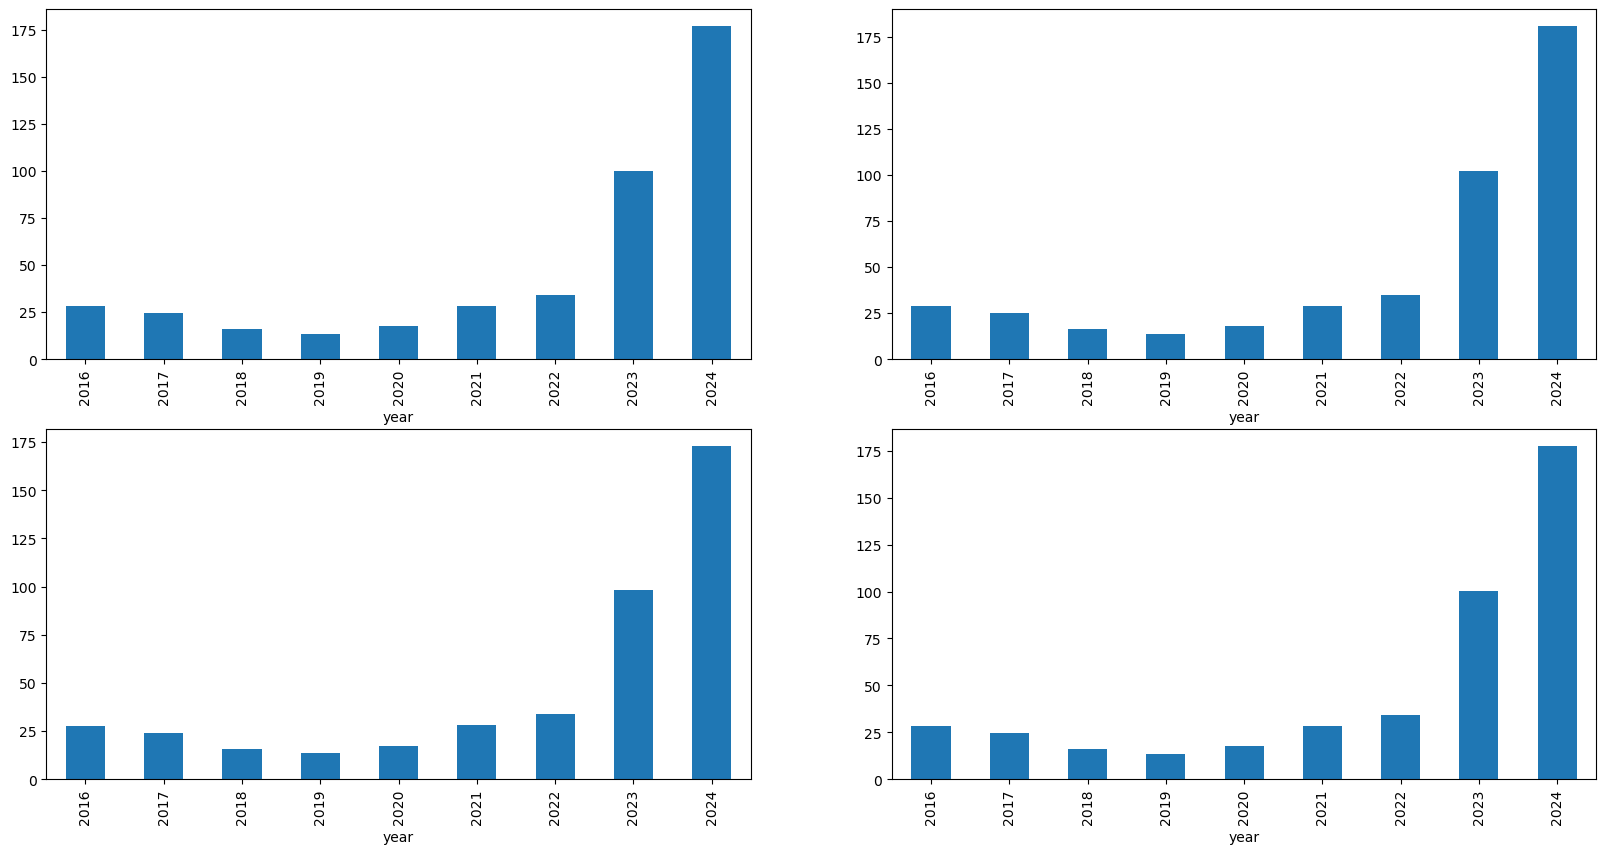

In [9]:
cols_to_keep = ['Open', 'High', 'Low', 'Close','Volume', 'Dividends', 'Stock Splits', 'EMA_10', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26', 'day', 'month', 'year', 'is_quarter_end']
df_1 = df[cols_to_keep]
df_1.head()

data_grouped = df_1.groupby('year').mean() 
plt.subplots(figsize=(20,10)) 
  
for i, col in enumerate(['Open', 'High', 'Low', 'Close']): 
  plt.subplot(2,2,i+1) 
  data_grouped[col].plot.bar() 
plt.show()

### Observations:
From the above bar graph, we can conclude that the stock prices have more than doubled from the year 2016 to that in 2024.

In [10]:
df_1.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA_10,PSARl_0.02_0.2,PSARs_0.02_0.2,...,BBM_5_2.0,BBU_5_2.0,ISA_9,ISB_26,ITS_9,IKS_26,ICS_26,day,month,year
is_quarter_end,,,,,,,,,,,,,,,,,,,,,
0,36.764296,37.483855,36.063616,36.820224,731673.541167,0.0,0.0,36.335703,34.463425,37.583834,...,36.564838,38.252110,34.262935,33.080618,36.307142,35.734939,39.682429,15.707434,6.103917,2019.982414
1,40.025695,40.771620,39.242422,40.009141,746191.093750,0.0,0.0,39.740464,37.597787,41.332617,...,39.976440,41.650946,35.929194,35.179050,39.740391,38.606109,41.381804,15.914062,7.429688,2019.973438


### Observations:
a. Prices are higher in the months which are quarter end as compared to that of the non-quarter end months.

b. The volume of trades is higher in the months which are quarter end.

### Next, we will add additional columns to help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only.

In [11]:
df_1['open-close'] = df_1['Open'] - df_1['Close'] 
df_1['low-high'] = df_1['Low'] - df_1['High'] 
df_1['target'] = np.where(df_1['Close'].shift(-1) > df_1['Close'], 1, 0)

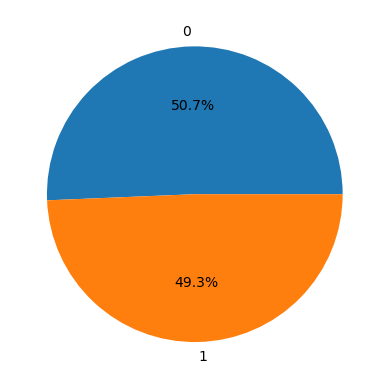

In [12]:
plt.pie(df_1['target'].value_counts().values, labels=[0, 1], autopct='%1.1f%%') 
plt.show()


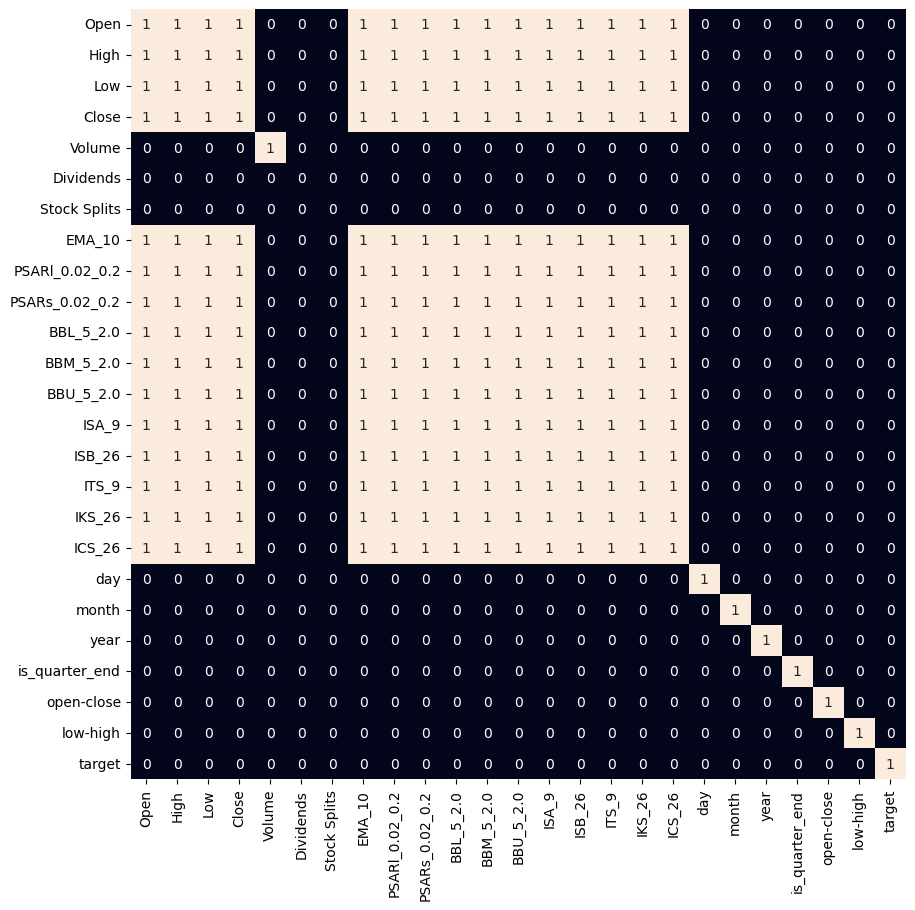

In [13]:
plt.figure(figsize=(10, 10)) 

# As our concern is with the highly 
# correlated features only so, we will visualize 
# our heatmap as per that criteria only. 
sns.heatmap(df_1.corr() > 0.9, annot=True, cbar=False) 
plt.show() 


### Observations:
From the above heatmap, we can say that there is a high correlation between Open, High, Low, and Close. Additionally, the added features are highly correlated with each other which means they should be remvoed before we build our model.

In [14]:
cols = ['Open', 'High', 'Low', 'Close','Volume', 'Dividends', 'Stock Splits', 'day', 'month', 'year', 'is_quarter_end', 'open-close', 'low-high', 'target']
df_2 = df_1[cols]
df_2.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,day,month,year,is_quarter_end,open-close,low-high,target
69546,24.000000,27.400000,23.730000,26.500000,13591500,0.0,0.0,22,9,2016,1,-2.500000,-3.670000,0
69547,25.670000,26.049999,24.129999,25.330000,2152500,0.0,0.0,23,9,2016,1,0.340000,-1.920000,0
69548,25.379999,25.760000,24.719999,25.260000,531800,0.0,0.0,26,9,2016,1,0.119999,-1.040001,0
69549,25.450001,25.500000,24.570000,24.600000,976700,0.0,0.0,27,9,2016,1,0.850000,-0.930000,1
69550,24.950001,26.799999,24.750000,26.540001,1071400,0.0,0.0,28,9,2016,1,-1.590000,-2.049999,1


## 3.4 Data Splitting and Normalization<a id="data"></a>

In [15]:
features = df_2[['open-close', 'low-high', 'is_quarter_end']] 
target = df_2['target'] 

scaler = StandardScaler() 
features = scaler.fit_transform(features) 

X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.1, random_state=2022) 
print(X_train.shape, X_valid.shape) 

(1701, 3) (190, 3)
